# Google Leak

## BGP data feature per ASN

In [ ]:
import pybgpstream
import editdistance
import pandas as pd
from datetime import datetime, timedelta

# Initialize the BGPStream
stream = pybgpstream.BGPStream(
    from_time="2018-04-25 08:30:00",
    until_time="2018-04-25 12:00:00",
    record_type="updates",
    collectors=["rrc00"]
)

# Function to initialize the feature dictionary
def init_features():
    return {
        "timestamp": None,
        "num_announcements" : 0, # Number of announcements
        "num_withdrawals" : 0, # Number of withdrawals:
        "num_implicit_withdrawals" : 0,  
        "num_duplicate_announcements" : 0,
        "num_duplicate_withdrawals" : 0,
        "num_announced_prefixes" : 0, # Number of announced prefixes
        "num_withdrawn_prefixes" : 0, # Number of withdrawn prefixes
        "max_announcements_per_prefix" : 0, # Max. announcements per prefix
        "avg_announcements_per_prefix" : 0, # Avg. announcements per prefix
        "num_new_announcements" : 0, # Not stored in RIB
        "num_new_announcements_after_withdrawal" : 0, 
        "max_path_length" : 0,
        "avg_path_length" : 0,
        "max_edit_distance" : 0,
        "avg_edit_distance" : 0,
        "avg_interarrival_time" : 0,
    }

# Initialize DataFrame to store the aggregated features
columns = list(init_features().keys())
df_features = pd.DataFrame(columns=columns)

# Initialize variables
routes = {}
A_per_prefix = {}
W_per_prefix = {}
path_len = []
inter_time = []
editDist = []

prevTime = 0
index = 0
# target_asn = "15169"
# target_asn = "37282"
target_asn = "4809"

# Initialize feature set for the first 5-minute window
current_window_start = datetime.strptime("2018-04-25 08:30:00", "%Y-%m-%d %H:%M:%S")
current_features = init_features()
current_features["timestamp"] = current_window_start

# Process BGP records
for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            # Final aggregation for the current window
            current_features["num_announced_prefixes"] = len(A_per_prefix)
            current_features["num_withdrawn_prefixes"] = len(W_per_prefix)
            A_per_prefix_values = A_per_prefix.values()
            if len(A_per_prefix_values) > 1:
                current_features["max_announcements_per_prefix"] = max(A_per_prefix_values)
                current_features["avg_announcements_per_prefix"] = round(sum(A_per_prefix_values) / len(A_per_prefix_values))

            if len(path_len) > 1:
                current_features["max_path_length"] = max(path_len)
                current_features["avg_path_length"] = round(sum(path_len) / len(path_len))

            if len(inter_time) > 1:
                current_features["avg_interarrival_time"] = round(sum(inter_time) * 1000 / len(inter_time))

            if len(editDist) > 1:
                current_features["max_edit_distance"] = max(editDist)
                current_features["avg_edit_distance"] = round(sum(editDist) / len(editDist))
            
            # Append the features to the DataFrame
            df_features = pd.concat([df_features, pd.DataFrame([current_features])], ignore_index=True)

            # Reset variables for the new window
            current_window_start += timedelta(minutes=5)
            current_features = init_features()
            current_features["timestamp"] = current_window_start
            routes = {}
            A_per_prefix = {}
            W_per_prefix = {}
            path_len = []
            inter_time = []
            editDist = []
            prevTime = 0
            index = 0

        if "prefix" not in update or "as-path" not in update:
            continue
        
        as_path = update['as-path'].split()
        origin_as = as_path[-1]
        if origin_as != target_asn:
            continue
        
        prefix = update["prefix"]
        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            current_features["num_announcements"] += 1

            path_len.append(len(as_path))

            if prefix not in A_per_prefix:
                A_per_prefix[prefix] = 0

            A_per_prefix[prefix] += 1

            if peer_asn not in routes[prefix][collector] or routes[prefix][collector][peer_asn] is None:
                current_features["num_new_announcements"] += 1
            elif routes[prefix][collector][peer_asn] == "w" + str(index):
                current_features["num_new_announcements_after_withdrawal"] += 1
            elif routes[prefix][collector][peer_asn][0] == "w":
                current_features["num_new_announcements"] += 1
            elif routes[prefix][collector][peer_asn] == ' '.join(as_path):
                current_features["num_duplicate_announcements"] += 1
            else:
                current_features["num_implicit_withdrawals"] += 1

                edist = editdistance.eval(routes[prefix][collector][peer_asn].split(" "), as_path)
                editDist.append(edist)

            routes[prefix][collector][peer_asn] = ' '.join(as_path)

        elif elem.type == 'W':
            current_features["num_withdrawals"] += 1

            if prefix not in W_per_prefix:
                W_per_prefix[prefix] = 0

            W_per_prefix[prefix] += 1

            if peer_asn in routes[prefix][collector] and routes[prefix][collector][peer_asn] == "w" + str(index):
                current_features["num_duplicate_withdrawals"] += 1

            routes[prefix][collector][peer_asn] = "w" + str(index)

        if prevTime != 0:
            iTime = int(elem.time) - prevTime
            if iTime > 0:
                inter_time.append(iTime)

        prevTime = int(elem.time)
        index += 1

# Final aggregation for the last window
current_features["num_announced_prefixes"] = len(A_per_prefix)
current_features["num_withdrawn_prefixes"] = len(W_per_prefix)
A_per_prefix_values = A_per_prefix.values()
if len(A_per_prefix_values) > 1:
    current_features["max_announcements_per_prefix"] = max(A_per_prefix_values)
    current_features["avg_announcements_per_prefix"] = round(sum(A_per_prefix_values) / len(A_per_prefix_values))

if len(path_len) > 1:
    current_features["max_path_length"] = max(path_len)
    current_features["avg_path_length"] = round(sum(path_len) / len(path_len))

if len(inter_time) > 1:
    current_features["avg_interarrival_time"] = round(sum(inter_time) * 1000 / len(inter_time))

if len(editDist) > 1:
    current_features["max_edit_distance"] = max(editDist)
    current_features["avg_edit_distance"] = round(sum(editDist) / len(editDist))

df_features = pd.concat([df_features, pd.DataFrame([current_features])], ignore_index=True)

# Display the DataFrame to verify
print(df_features)

# Save the DataFrame to a CSV file if needed
df_features.to_csv(f"bgp_features_5min_windows_{target_asn}.csv", index=False)


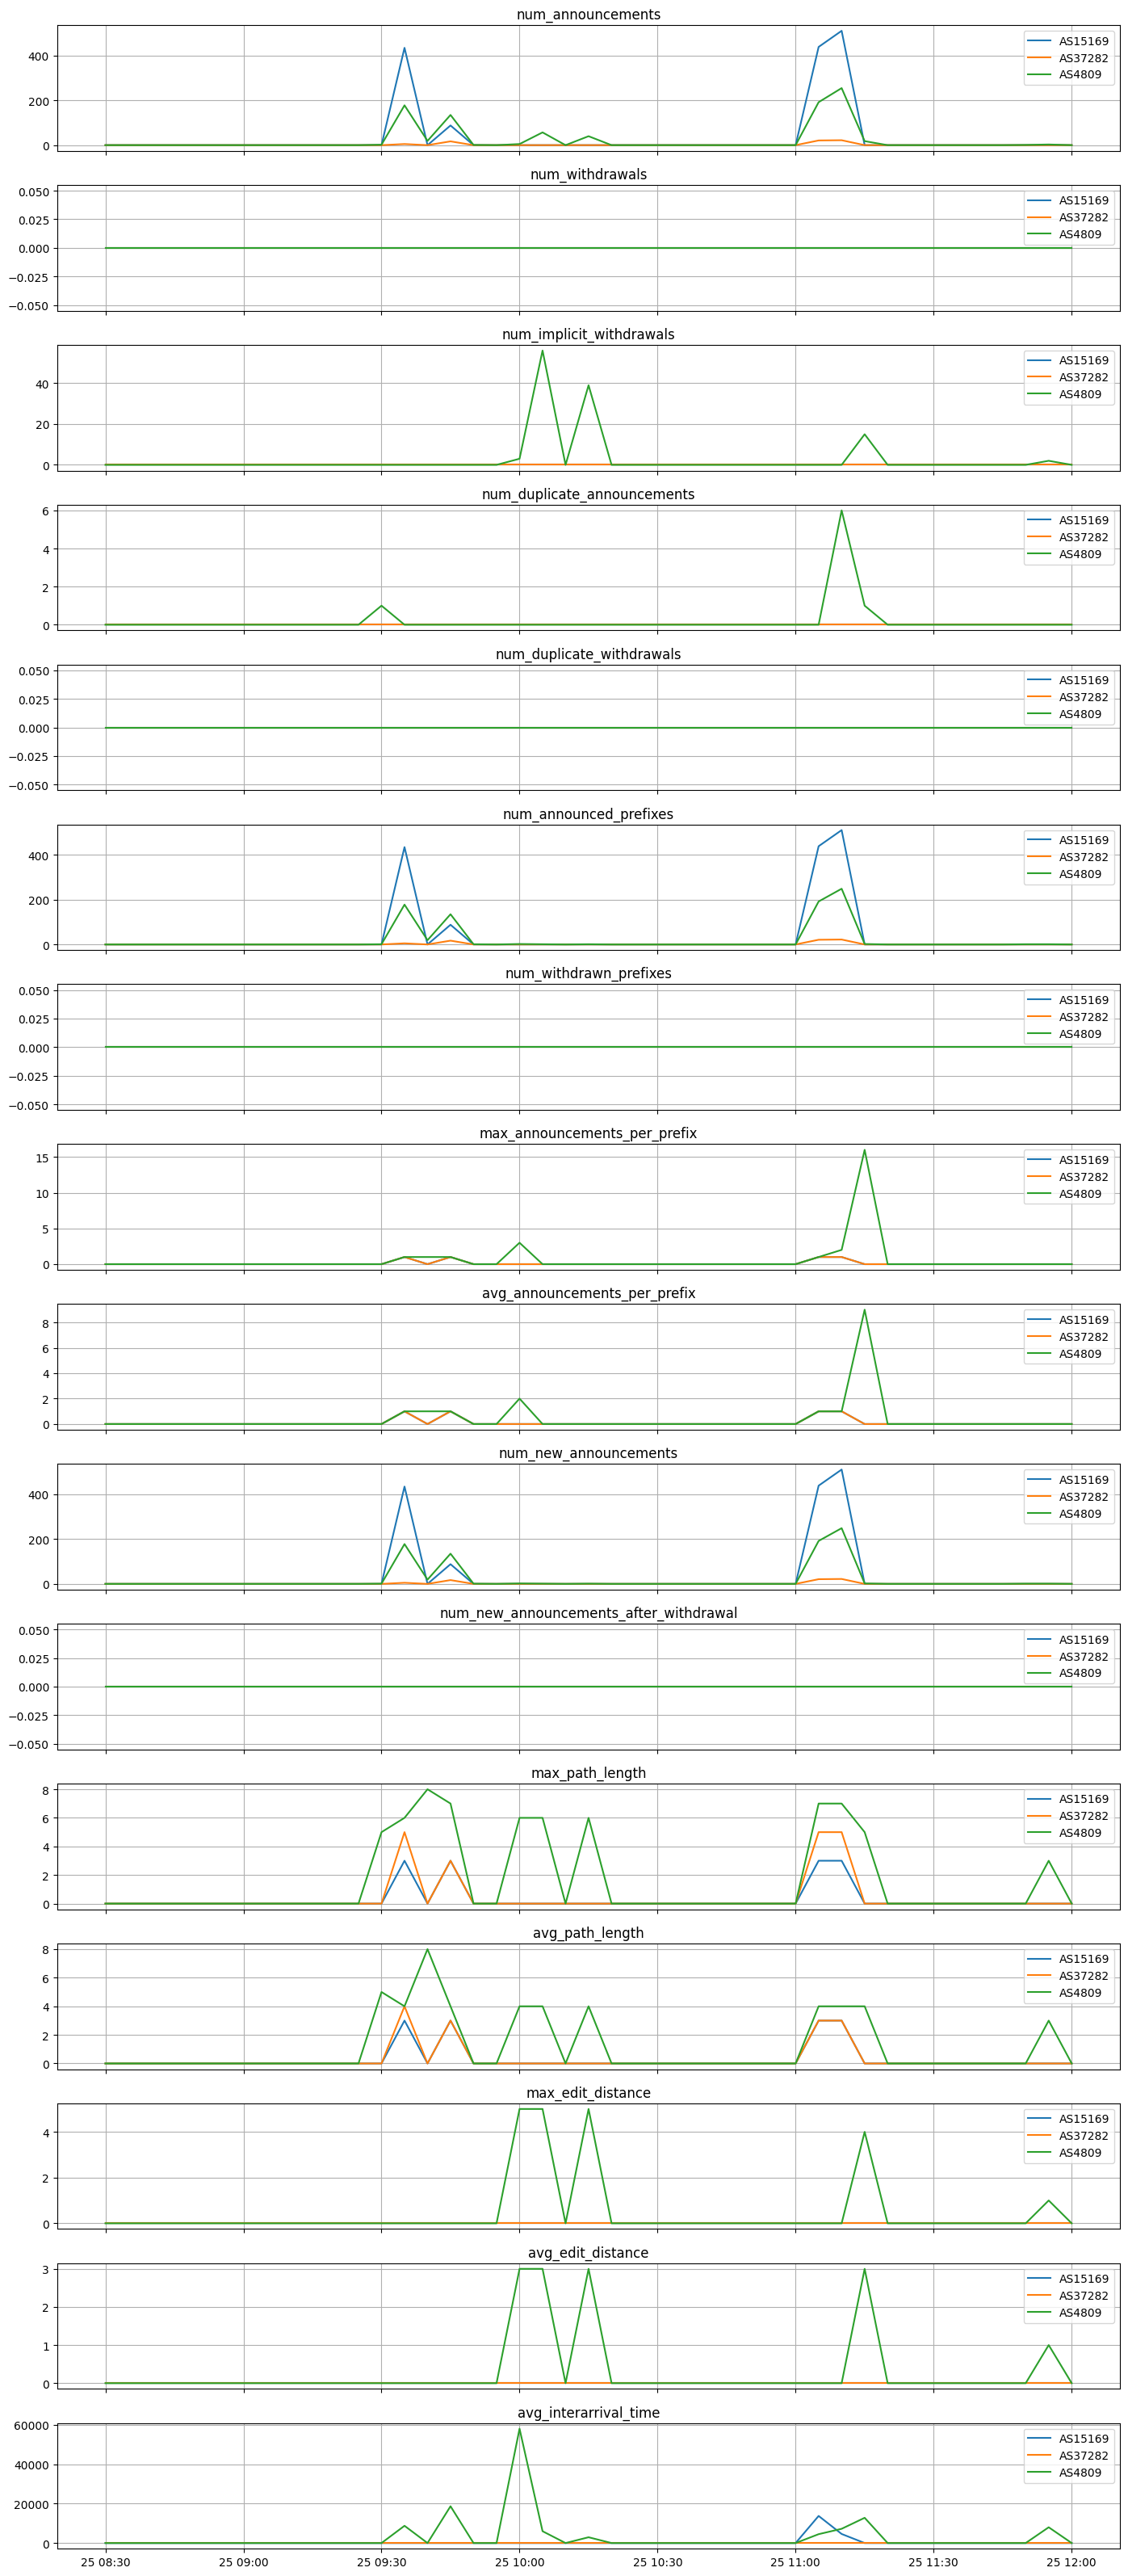

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data for each ASN
asn_15169 = pd.read_csv("bgp_features_5min_windows_AS15169.csv")
asn_37282 = pd.read_csv("bgp_features_5min_windows_AS37282.csv")
asn_4809 = pd.read_csv("bgp_features_5min_windows_AS4809.csv")

# Add a column to each DataFrame to identify the ASN
asn_15169["asn"] = "15169"
asn_37282["asn"] = "37282"
asn_4809["asn"] = "4809"

# Combine the data into a single DataFrame
combined_df = pd.concat([asn_15169, asn_37282, asn_4809], ignore_index=True)

# Convert the timestamp to a datetime object
combined_df["timestamp"] = pd.to_datetime(combined_df["timestamp"])

# Set the timestamp as the index
combined_df.set_index("timestamp", inplace=True)

# Get the list of features to plot (excluding the 'asn' column)
features_to_plot = [col for col in combined_df.columns if col != "asn"]

# Plot the relevant features over time for each ASN
fig, axes = plt.subplots(len(features_to_plot), 1, figsize=(14, len(features_to_plot) * 2), sharex=True)
for i, feature in enumerate(features_to_plot):
    for asn in ["15169", "37282", "4809"]:
        data = combined_df[combined_df["asn"] == asn]
        axes[i].plot(data.index, data[feature], label=f"AS{asn}")
    axes[i].set_title(feature)
    axes[i].legend(loc="upper right")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## ASN feature

In [7]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd

def build_routes_as(routes):
    routes_as = {}
    for prefix in routes:
        for collector in routes[prefix]:
            for peer_asn in routes[prefix][collector]:
                path = routes[prefix][collector][peer_asn]
                if len(path) == 0:
                    continue
                asn = path[-1]
                if asn not in routes_as:
                    routes_as[asn] = {}
                routes_as[asn][prefix] = path
    return routes_as

def extract_features(index, routes, old_routes_as, target_asn, temp_counts):
    features = {
        "timestamp": None,
        "asn": target_asn,
        "num_routes": 0,
        "num_new_routes": 0,
        "num_withdrawals": 0,
        "num_origin_changes": 0,
        "num_route_changes": 0,
        "max_path_length": 0,
        "avg_path_length": 0,
        "max_edit_distance": 0,
        "avg_edit_distance": 0,
        "num_announcements": temp_counts["num_announcements"],
        "num_withdrawals": temp_counts["num_withdrawals"],
        "num_unique_prefixes_announced": 0
    }

    routes_as = build_routes_as(routes)

    if index > 0:
        if target_asn in routes_as:
            num_routes = len(routes_as[target_asn])
            sum_path_length = 0
            sum_edit_distance = 0

            for prefix in routes_as[target_asn].keys():
                if target_asn in old_routes_as and prefix in old_routes_as[target_asn]:
                    path = routes_as[target_asn][prefix]
                    path_old = old_routes_as[target_asn][prefix]

                    if path != path_old:
                        features["num_route_changes"] += 1

                    if path[-1] != path_old[-1]:
                        features["num_origin_changes"] += 1

                    path_length = len(path)
                    path_old_length = len(path_old)

                    sum_path_length += path_length
                    if path_length > features["max_path_length"]:
                        features["max_path_length"] = path_length

                    edist = editdistance.eval(path, path_old)
                    sum_edit_distance += edist
                    if edist > features["max_edit_distance"]:
                        features["max_edit_distance"] = edist
                else:
                    features["num_new_routes"] += 1

            features["num_routes"] = num_routes
            features["avg_path_length"] = sum_path_length / num_routes
            features["avg_edit_distance"] = sum_edit_distance / num_routes

        if target_asn in old_routes_as:
            for prefix in old_routes_as[target_asn].keys():
                if not (target_asn in routes_as and prefix in routes_as[target_asn]):
                    features["num_withdrawals"] += 1

    # Add the number of unique prefixes announced
    features["num_unique_prefixes_announced"] = len(routes_as.get(target_asn, {}))

    return features, routes_as

def extract_bgp_data(target_asn, from_time, until_time, collectors=['rrc00'], output_file='bgp_features.csv'):
    stream = pybgpstream.BGPStream(
        from_time=from_time,
        until_time=until_time,
        record_type="updates",
        collectors=collectors
    )

    all_features = []
    old_routes_as = {}
    routes = {}
    current_window_start = datetime.strptime(from_time, "%Y-%m-%d %H:%M:%S")
    index = 0

    # Initialize temporary counts for announcements and withdrawals
    temp_counts = {
        "num_announcements": 0,
        "num_withdrawals": 0
    }

    record_count = 0
    element_count = 0

    for rec in stream.records():
        record_count += 1
        for elem in rec:
            element_count += 1
            update = elem.fields
            elem_time = datetime.utcfromtimestamp(elem.time)

            if elem_time >= current_window_start + timedelta(minutes=5):
                features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
                features['timestamp'] = current_window_start
                all_features.append(features)

                # Reset for the new window
                current_window_start += timedelta(minutes=5)
                routes = {}
                index += 1
                temp_counts = {
                    "num_announcements": 0,
                    "num_withdrawals": 0
                }

            prefix = update.get("prefix")
            if prefix is None:
                continue

            peer_asn = update.get("peer_asn", "unknown")
            collector = rec.collector

            if prefix not in routes:
                routes[prefix] = {}
            if collector not in routes[prefix]:
                routes[prefix][collector] = {}

            if elem.type == 'A':
                path = update['as-path'].split()
                if path[-1] == target_asn:
                    routes[prefix][collector][peer_asn] = path
                    temp_counts["num_announcements"] += 1
            elif elem.type == 'W':
                if prefix in routes and collector in routes[prefix]:
                    if peer_asn in routes[prefix][collector]:
                        if routes[prefix][collector][peer_asn][-1] == target_asn:
                            routes[prefix][collector].pop(peer_asn, None)
                            temp_counts["num_withdrawals"] += 1

    print(f"Total records processed: {record_count}")
    print(f"Total elements processed: {element_count}")

    # Final aggregation for the last window
    features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
    features['timestamp'] = current_window_start
    all_features.append(features)

    df_features = pd.json_normalize(all_features, sep='_').fillna(0)
    df_features.to_csv(output_file, index=False)
    print(f"Data saved to {output_file}")

    return df_features


def plot_statistics(df_features, target_asn):
    numeric_cols = df_features.select_dtypes(include=['number']).columns

    # Define the color map
    num_colors = len(numeric_cols)
    color_map = cm.get_cmap('tab20', num_colors)

    # Plotting the statistics
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(numeric_cols):
        plt.plot(df_features['timestamp'], df_features[col], label=col, color=color_map(i))

    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.title(f'Statistics for ASN {target_asn}')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def detect_anomalies(df, numeric_cols, threshold_multiplier=2):
    diff = df[numeric_cols].diff().abs()
    thresholds = diff.mean() + threshold_multiplier * diff.std()
    anomalies = (diff > thresholds).any(axis=1)
    
    # Initialize the anomaly_status column with "no anomalies detected"
    df['anomaly_status'] = "no anomalies detected"
    
    # Label anomalies and add reasons
    for idx in df[anomalies].index:
        reasons = []
        for col in numeric_cols:
            if diff.loc[idx, col] > thresholds[col]:
                reasons.append(f"{col}={df.loc[idx, col]}")
        if reasons:
            df.at[idx, 'anomaly_status'] = f"anomaly due to high value of {', '.join(reasons)}"
    
    return df

def detect_anomalies_new(df, numeric_cols, threshold_multiplier=2):
    diff = df[numeric_cols].diff().abs()
    mean_values = diff.mean()
    std_values = diff.std()
    thresholds = mean_values + threshold_multiplier * std_values
    anomalies = (diff > thresholds).any(axis=1)
    
    # Initialize the anomaly_status column with "No anomalies detected"
    df['anomaly_status'] = "No anomalies detected"
    
    # Label anomalies and add detailed reasons
    for idx in df[anomalies].index:
        reasons = []
        for col in numeric_cols:
            if diff.loc[idx, col] > thresholds[col]:
                value = df.loc[idx, col]
                rounded_mean = round(mean_values[col], 2)
                rounded_std = round(std_values[col], 2)
                reasons.append(f"{col}: observed value={value}, expected mean={rounded_mean}, standard deviation={rounded_std}")
        if reasons:
            df.at[idx, 'anomaly_status'] = f"Anomaly detected due to the following deviations: {', '.join(reasons)}"
    
    return df


# Google Leak

In [14]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd


stream = pybgpstream.BGPStream(
    from_time="2017-08-25 03:00:00",
    until_time="2017-08-25 05:00:00",
    record_type="updates",
    collectors=["rrc00"]
)

target_asn = "15169"
# target_asn = "37282"
# target_asn = "4809"
all_features = []
old_routes_as = {}
routes = {}
current_window_start = datetime.strptime("2017-08-25 03:00:00", "%Y-%m-%d %H:%M:%S")
index = 0

# Initialize temporary counts for announcements and withdrawals
temp_counts = {
    "num_announcements": 0,
    "num_withdrawals": 0
}

for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
            features['timestamp'] = current_window_start
            all_features.append(features)

            # Reset for the new window
            current_window_start += timedelta(minutes=5)
            routes = {}
            index += 1
            temp_counts = {
                "num_announcements": 0,
                "num_withdrawals": 0
            }

        prefix = update.get("prefix")
        if prefix is None:
            continue

        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            path = update['as-path'].split()
            if path[-1] == target_asn:
                routes[prefix][collector][peer_asn] = path
                temp_counts["num_announcements"] += 1
        elif elem.type == 'W':
            if prefix in routes and collector in routes[prefix]:
                if peer_asn in routes[prefix][collector]:
                    if routes[prefix][collector][peer_asn][-1] == target_asn:
                        routes[prefix][collector].pop(peer_asn, None)
                        temp_counts["num_withdrawals"] += 1

# Final aggregation for the last window
features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
features['timestamp'] = current_window_start
all_features.append(features)

df_features = pd.json_normalize(all_features, sep='_').fillna(0)
df_features.to_csv(f'bgp_features_asn_{target_asn}_google_leak.csv', index=False)
print(df_features)

             timestamp    asn  num_routes  num_new_routes  num_withdrawals  \
0  2017-08-25 03:00:00  15169           0               0                0   
1  2017-08-25 03:05:00  15169           0               0                0   
2  2017-08-25 03:10:00  15169           0               0                0   
3  2017-08-25 03:15:00  15169           0               0                0   
4  2017-08-25 03:20:00  15169         730             730                0   
..                 ...    ...         ...             ...              ...   
56 2017-08-25 07:40:00  15169           0               0                0   
57 2017-08-25 07:45:00  15169           0               0                0   
58 2017-08-25 07:50:00  15169           0               0                0   
59 2017-08-25 07:55:00  15169           0               0                0   
60 2017-08-25 08:00:00  15169           0               0                0   

    num_origin_changes  num_route_changes  max_path_length  avg

In [5]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd

target_asn = "15169"
# target_asn = "37282"
# target_asn = "4809"
df_features = pd.read_csv('/home/hb/BGP_data_analysis/pybgpstream/bgp_features_asn_15169_google_leak.csv')

In [6]:
# Calculate the difference between consecutive rows
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

# Detect anomalies
df_features = detect_anomalies(df_features, numeric_cols, threshold_multiplier=2)
print(df_features)

# Save the updated DataFrame with anomalies
df_features.to_csv(f'bgp_features_asn_{target_asn}_with_labels.csv', index=False)

             timestamp    asn  num_routes  num_new_routes  num_withdrawals  \
0  2017-08-25 03:00:00  15169           0               0                0   
1  2017-08-25 03:05:00  15169           0               0                0   
2  2017-08-25 03:10:00  15169           0               0                0   
3  2017-08-25 03:15:00  15169           0               0                0   
4  2017-08-25 03:20:00  15169         730             730                0   
..                 ...    ...         ...             ...              ...   
56 2017-08-25 07:40:00  15169           0               0                0   
57 2017-08-25 07:45:00  15169           0               0                0   
58 2017-08-25 07:50:00  15169           0               0                0   
59 2017-08-25 07:55:00  15169           0               0                0   
60 2017-08-25 08:00:00  15169           0               0                0   

    num_origin_changes  num_route_changes  max_path_length  avg

/tmp/ipykernel_211634/1777972919.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


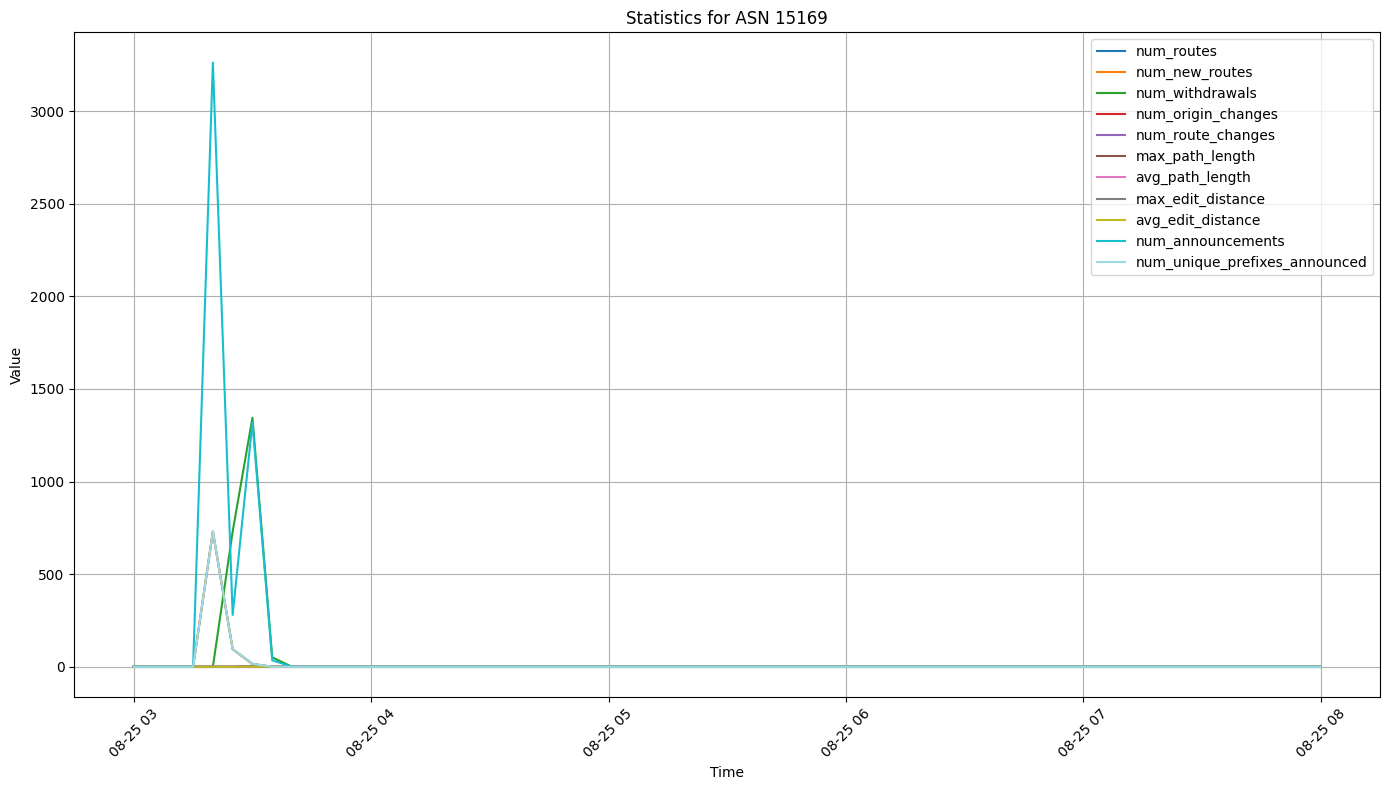

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

# Define the color map
num_colors = len(numeric_cols)
color_map = cm.get_cmap('tab20', num_colors)

# Plotting the statistics
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols):
    plt.plot(df_features['timestamp'], df_features[col], label=col, color=color_map(i))

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Statistics for ASN {target_asn}')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [56]:
# Count the number of anomalies
num_anomalies = df_features[df_features['anomaly_status'].str.contains("anomaly")].shape[0]

print(f"Number of anomalies: {num_anomalies}")


Number of anomalies: 7


# April 2018: 1300 IP addresses within Amazon Web Services space were hijacked by eNet
eNET (AS10297)
Hurricane Electric (AS6939)

In [19]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd

stream = pybgpstream.BGPStream(
    from_time="2018-04-25 10:00:00",
    until_time="2018-04-25 13:00:00",
    record_type="updates",
    collectors= ["rrc00", "rrc06"]
)
# target_asn = "10297"
target_asn = "6939"

all_features = []
old_routes_as = {}
routes = {}
current_window_start = datetime.strptime("2018-04-25 10:00:00", "%Y-%m-%d %H:%M:%S")
index = 0

# Initialize temporary counts for announcements and withdrawals
temp_counts = {
    "num_announcements": 0,
    "num_withdrawals": 0
}

for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
            features['timestamp'] = current_window_start
            all_features.append(features)

            # Reset for the new window
            current_window_start += timedelta(minutes=5)
            routes = {}
            index += 1
            temp_counts = {
                "num_announcements": 0,
                "num_withdrawals": 0
            }

        prefix = update.get("prefix")
        if prefix is None:
            continue

        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            path = update['as-path'].split()
            if path[-1] == target_asn:
                routes[prefix][collector][peer_asn] = path
                temp_counts["num_announcements"] += 1
        elif elem.type == 'W':
            if prefix in routes and collector in routes[prefix]:
                if peer_asn in routes[prefix][collector]:
                    if routes[prefix][collector][peer_asn][-1] == target_asn:
                        routes[prefix][collector].pop(peer_asn, None)
                        temp_counts["num_withdrawals"] += 1

# Final aggregation for the last window
features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
features['timestamp'] = current_window_start
all_features.append(features)

df_features = pd.json_normalize(all_features, sep='_').fillna(0)
df_features.to_csv(f'bgp_features_asn_{target_asn}_amazone_hijack.csv', index=False)
print(df_features)

             timestamp   asn  num_routes  num_new_routes  num_withdrawals  \
0  2018-04-25 10:00:00  6939           0               0                0   
1  2018-04-25 10:05:00  6939           0               0                0   
2  2018-04-25 10:10:00  6939           0               0                0   
3  2018-04-25 10:15:00  6939           0               0                0   
4  2018-04-25 10:20:00  6939           0               0                0   
5  2018-04-25 10:25:00  6939           0               0                0   
6  2018-04-25 10:30:00  6939           0               0                0   
7  2018-04-25 10:35:00  6939           0               0                0   
8  2018-04-25 10:40:00  6939           0               0                0   
9  2018-04-25 10:45:00  6939           0               0                0   
10 2018-04-25 10:50:00  6939           0               0                0   
11 2018-04-25 10:55:00  6939           0               0                0   

/tmp/ipykernel_211634/1777972919.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


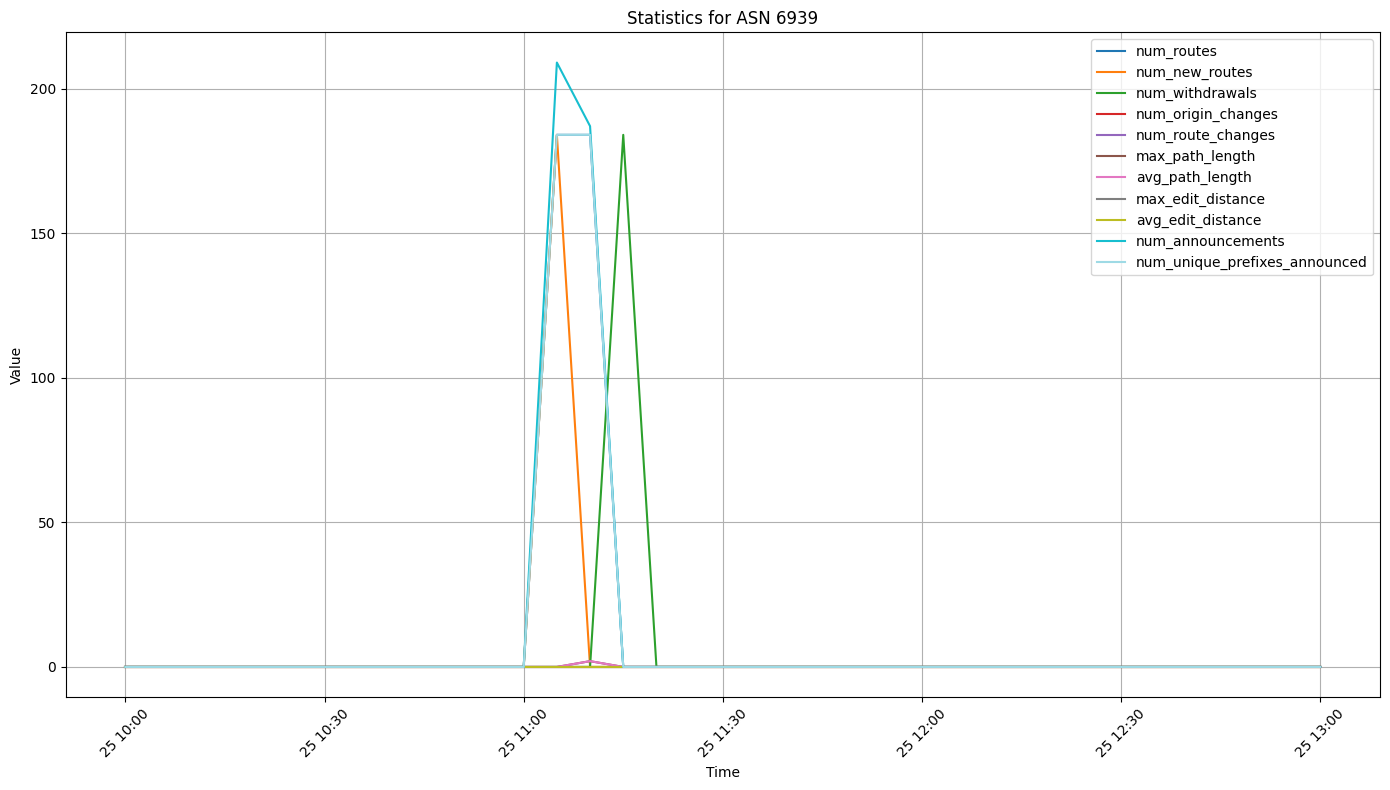

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

# Define the color map
num_colors = len(numeric_cols)
color_map = cm.get_cmap('tab20', num_colors)

# Plotting the statistics
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols):
    plt.plot(df_features['timestamp'], df_features[col], label=col, color=color_map(i))

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Statistics for ASN {target_asn}')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd

target_asn = "10297"
df_features = pd.read_csv('/home/hb/BGP_data_analysis/pybgpstream/bgp_features_asn_6939_amazone_hijack.csv')
# Calculate the difference between consecutive rows
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

# Detect anomalies
df_features = detect_anomalies(df_features, numeric_cols, threshold_multiplier=2)
print(df_features)

# Save the updated DataFrame with anomalies
df_features.to_csv(f'bgp_features_asn_{target_asn}_with_labels.csv', index=False)

             timestamp   asn  num_routes  num_new_routes  num_withdrawals  \
0  2018-04-25 10:00:00  6939           0               0                0   
1  2018-04-25 10:05:00  6939           0               0                0   
2  2018-04-25 10:10:00  6939           0               0                0   
3  2018-04-25 10:15:00  6939           0               0                0   
4  2018-04-25 10:20:00  6939           0               0                0   
5  2018-04-25 10:25:00  6939           0               0                0   
6  2018-04-25 10:30:00  6939           0               0                0   
7  2018-04-25 10:35:00  6939           0               0                0   
8  2018-04-25 10:40:00  6939           0               0                0   
9  2018-04-25 10:45:00  6939           0               0                0   
10 2018-04-25 10:50:00  6939           0               0                0   
11 2018-04-25 10:55:00  6939           0               0                0   

# Traffic for Google, Apple, Facebook, Microsoft and other tech giants routed through Russia

Origin AS of 39523

In [10]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd


stream = pybgpstream.BGPStream(
    from_time="2017-12-12 03:00:00",
    until_time="2017-12-12 08:00:00",
    record_type="updates",
    collectors=["route-views2", "route-views3", "route-views4", "ris-ripe"]
)

target_asn = "39523"
all_features = []
old_routes_as = {}
routes = {}
current_window_start = datetime.strptime("2017-12-12 04:00:00", "%Y-%m-%d %H:%M:%S")
index = 0

# Initialize temporary counts for announcements and withdrawals
temp_counts = {
    "num_announcements": 0,
    "num_withdrawals": 0
}

for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
            features['timestamp'] = current_window_start
            all_features.append(features)

            # Reset for the new window
            current_window_start += timedelta(minutes=5)
            routes = {}
            index += 1
            temp_counts = {
                "num_announcements": 0,
                "num_withdrawals": 0
            }

        prefix = update.get("prefix")
        if prefix is None:
            continue

        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            path = update['as-path'].split()
            if path[-1] == target_asn:
                routes[prefix][collector][peer_asn] = path
                temp_counts["num_announcements"] += 1
        elif elem.type == 'W':
            if prefix in routes and collector in routes[prefix]:
                if peer_asn in routes[prefix][collector]:
                    if routes[prefix][collector][peer_asn][-1] == target_asn:
                        routes[prefix][collector].pop(peer_asn, None)
                        temp_counts["num_withdrawals"] += 1

# Final aggregation for the last window
features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
features['timestamp'] = current_window_start
all_features.append(features)

df_features = pd.json_normalize(all_features, sep='_').fillna(0)
df_features.to_csv(f'bgp_features_asn_{target_asn}_russian_hijack.csv', index=False)
print(df_features)

             timestamp    asn  num_routes  num_new_routes  num_withdrawals  \
0  2017-12-12 04:00:00  39523           0               0                0   
1  2017-12-12 04:05:00  39523           0               0                0   
2  2017-12-12 04:10:00  39523           0               0                0   
3  2017-12-12 04:15:00  39523           0               0                0   
4  2017-12-12 04:20:00  39523           0               0                0   
5  2017-12-12 04:25:00  39523           0               0                0   
6  2017-12-12 04:30:00  39523           0               0                0   
7  2017-12-12 04:35:00  39523           0               0                0   
8  2017-12-12 04:40:00  39523          77              77              393   
9  2017-12-12 04:45:00  39523          50               3             1470   
10 2017-12-12 04:50:00  39523           0               0               50   
11 2017-12-12 04:55:00  39523           0               0       

/tmp/ipykernel_219293/1777972919.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


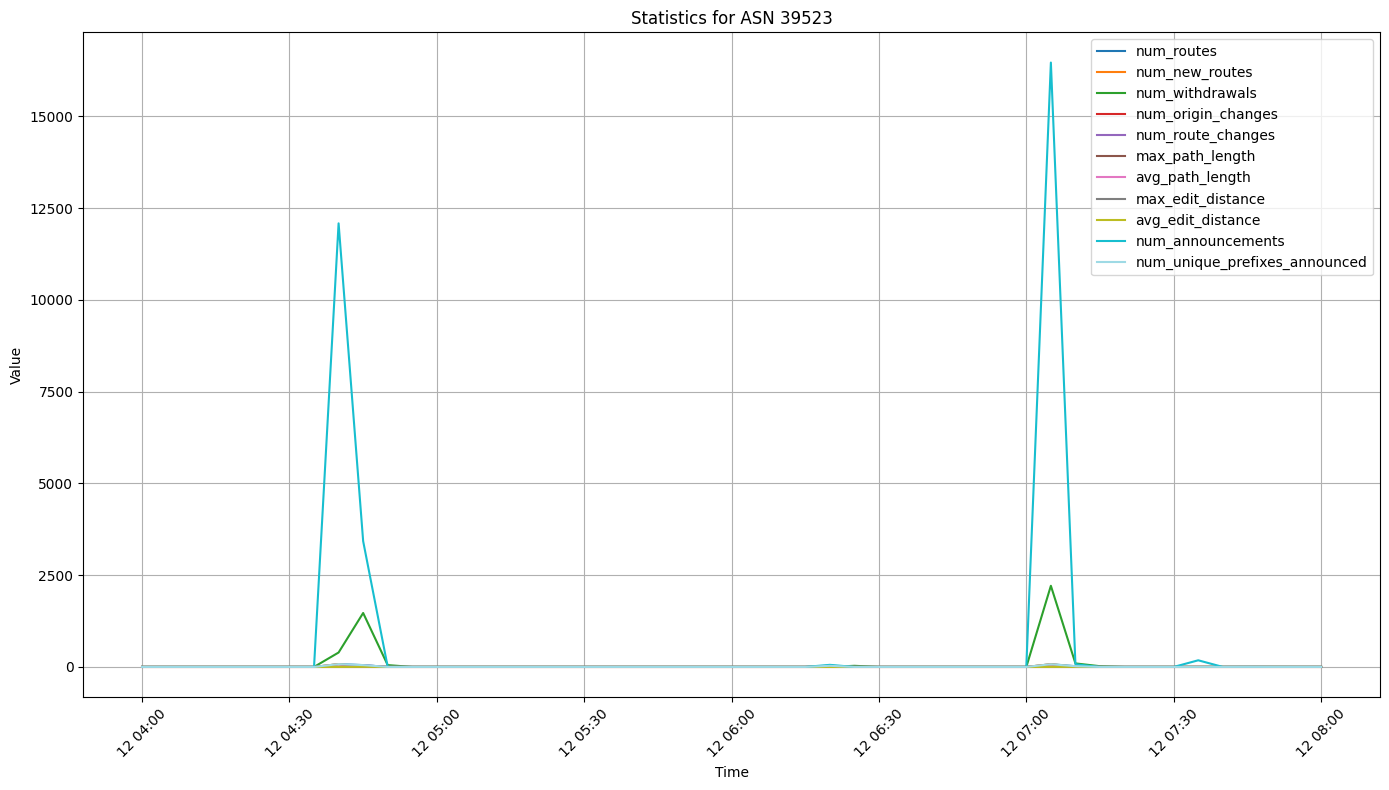

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

# Define the color map
num_colors = len(numeric_cols)
color_map = cm.get_cmap('tab20', num_colors)

# Plotting the statistics
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols):
    plt.plot(df_features['timestamp'], df_features[col], label=col, color=color_map(i))

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Statistics for ASN {target_asn}')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
df_features = pd.read_csv("/home/hb/dataset_bgp/bgp_tab_dataset/bgp_features_asn_39523_russian_hijack.csv")
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

df_features = detect_anomalies(df_features, numeric_cols, threshold_multiplier=2)
print(df_features[['timestamp', 'anomaly_status']])
df_features.to_csv(f'bgp_features_asn_39523_russian_hijack_with_labels.csv', index=False)

             timestamp                                     anomaly_status
0  2017-12-12 04:00:00                              no anomalies detected
1  2017-12-12 04:05:00                              no anomalies detected
2  2017-12-12 04:10:00                              no anomalies detected
3  2017-12-12 04:15:00                              no anomalies detected
4  2017-12-12 04:20:00                              no anomalies detected
5  2017-12-12 04:25:00                              no anomalies detected
6  2017-12-12 04:30:00                              no anomalies detected
7  2017-12-12 04:35:00                              no anomalies detected
8  2017-12-12 04:40:00  anomaly due to high value of num_routes=77, nu...
9  2017-12-12 04:45:00  anomaly due to high value of num_new_routes=3,...
10 2017-12-12 04:50:00  anomaly due to high value of num_routes=0, num...
11 2017-12-12 04:55:00                              no anomalies detected
12 2017-12-12 05:00:00                

# April 8, 2010 Chinese ISP hijacks the Internet
AS23724

In [13]:
import pybgpstream
import editdistance
from datetime import datetime, timedelta
import pandas as pd


stream = pybgpstream.BGPStream(
    from_time="2010-4-12 07:00:00",
    until_time="2010-4-12 22:00:00",
    record_type="updates",
    collectors=["route-views2", "route-views3", "route-views4", "ris-ripe"]
)

target_asn = "23724"
all_features = []
old_routes_as = {}
routes = {}
current_window_start = datetime.strptime("2010-4-12 07:00:00", "%Y-%m-%d %H:%M:%S")
index = 0

# Initialize temporary counts for announcements and withdrawals
temp_counts = {
    "num_announcements": 0,
    "num_withdrawals": 0
}

for rec in stream.records():
    for elem in rec:
        update = elem.fields
        elem_time = datetime.utcfromtimestamp(elem.time)
        
        if elem_time >= current_window_start + timedelta(minutes=5):
            features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
            features['timestamp'] = current_window_start
            all_features.append(features)

            # Reset for the new window
            current_window_start += timedelta(minutes=5)
            routes = {}
            index += 1
            temp_counts = {
                "num_announcements": 0,
                "num_withdrawals": 0
            }

        prefix = update.get("prefix")
        if prefix is None:
            continue

        peer_asn = update.get("peer_asn", "unknown")
        collector = rec.collector

        if prefix not in routes:
            routes[prefix] = {}
        if collector not in routes[prefix]:
            routes[prefix][collector] = {}

        if elem.type == 'A':
            path = update['as-path'].split()
            if path[-1] == target_asn:
                routes[prefix][collector][peer_asn] = path
                temp_counts["num_announcements"] += 1
        elif elem.type == 'W':
            if prefix in routes and collector in routes[prefix]:
                if peer_asn in routes[prefix][collector]:
                    if routes[prefix][collector][peer_asn][-1] == target_asn:
                        routes[prefix][collector].pop(peer_asn, None)
                        temp_counts["num_withdrawals"] += 1

# Final aggregation for the last window
features, old_routes_as = extract_features(index, routes, old_routes_as, target_asn, temp_counts)
features['timestamp'] = current_window_start
all_features.append(features)

df_features = pd.json_normalize(all_features, sep='_').fillna(0)
df_features.to_csv(f'bgp_features_asn_{target_asn}_chinese_isp.csv', index=False)
print(df_features)

              timestamp    asn  num_routes  num_new_routes  num_withdrawals  \
0   2010-04-12 07:00:00  23724           0               0                0   
1   2010-04-12 07:05:00  23724           0               0                0   
2   2010-04-12 07:10:00  23724           0               0                0   
3   2010-04-12 07:15:00  23724           0               0                0   
4   2010-04-12 07:20:00  23724           0               0                0   
..                  ...    ...         ...             ...              ...   
176 2010-04-12 21:40:00  23724           0               0                0   
177 2010-04-12 21:45:00  23724           0               0                0   
178 2010-04-12 21:50:00  23724           0               0                0   
179 2010-04-12 21:55:00  23724           0               0                0   
180 2010-04-12 22:00:00  23724           0               0                0   

     num_origin_changes  num_route_changes  max_pat

/tmp/ipykernel_219293/1777972919.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


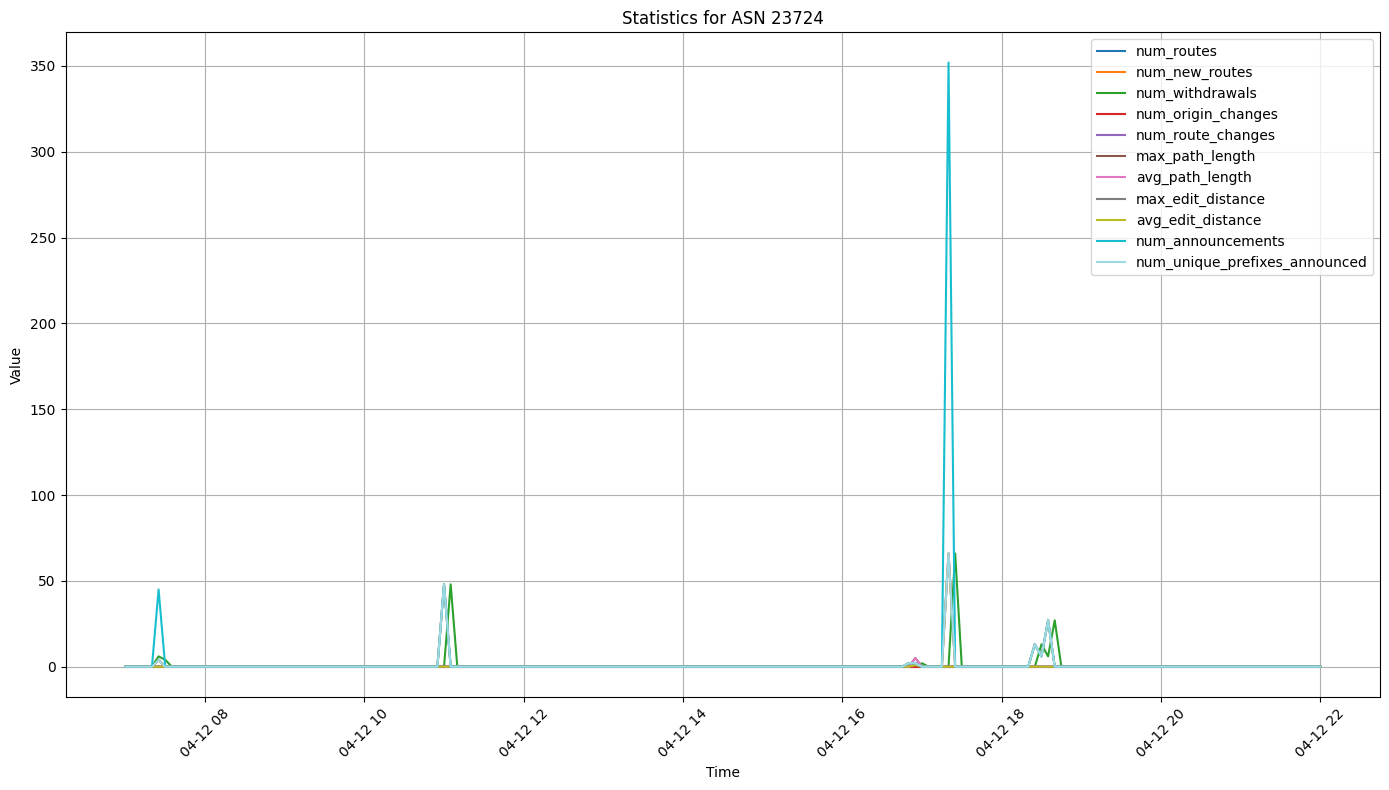

In [14]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

# Define the color map
num_colors = len(numeric_cols)
color_map = cm.get_cmap('tab20', num_colors)

# Plotting the statistics
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols):
    plt.plot(df_features['timestamp'], df_features[col], label=col, color=color_map(i))

plt.xlabel('Time')
plt.ylabel('Value')
plt.title(f'Statistics for ASN {target_asn}')
plt.legend(loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [14]:
df_features = pd.read_csv("/home/hb/dataset_bgp/bgp_tab_dataset/bgp_features_asn_23724_chinese_isp.csv")
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

df_features = detect_anomalies(df_features, numeric_cols, threshold_multiplier=2)
print(df_features[['timestamp', 'anomaly_status']])
df_features.to_csv(f'bgp_features_asn_23724_chinese_isp_with_labels.csv', index=False)

              timestamp         anomaly_status
0   2010-04-12 07:00:00  no anomalies detected
1   2010-04-12 07:05:00  no anomalies detected
2   2010-04-12 07:10:00  no anomalies detected
3   2010-04-12 07:15:00  no anomalies detected
4   2010-04-12 07:20:00  no anomalies detected
..                  ...                    ...
176 2010-04-12 21:40:00  no anomalies detected
177 2010-04-12 21:45:00  no anomalies detected
178 2010-04-12 21:50:00  no anomalies detected
179 2010-04-12 21:55:00  no anomalies detected
180 2010-04-12 22:00:00  no anomalies detected

[181 rows x 2 columns]


# ROS - Special Operations Group of the Italian National Military police

AS31034
(2013, 7, 3, 4, 0, 0)

Total records processed: 28906329
Total elements processed: 58800947
Data saved to bgp_features_asn_31034_ROS.csv


/tmp/ipykernel_489684/1722542296.py:180: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


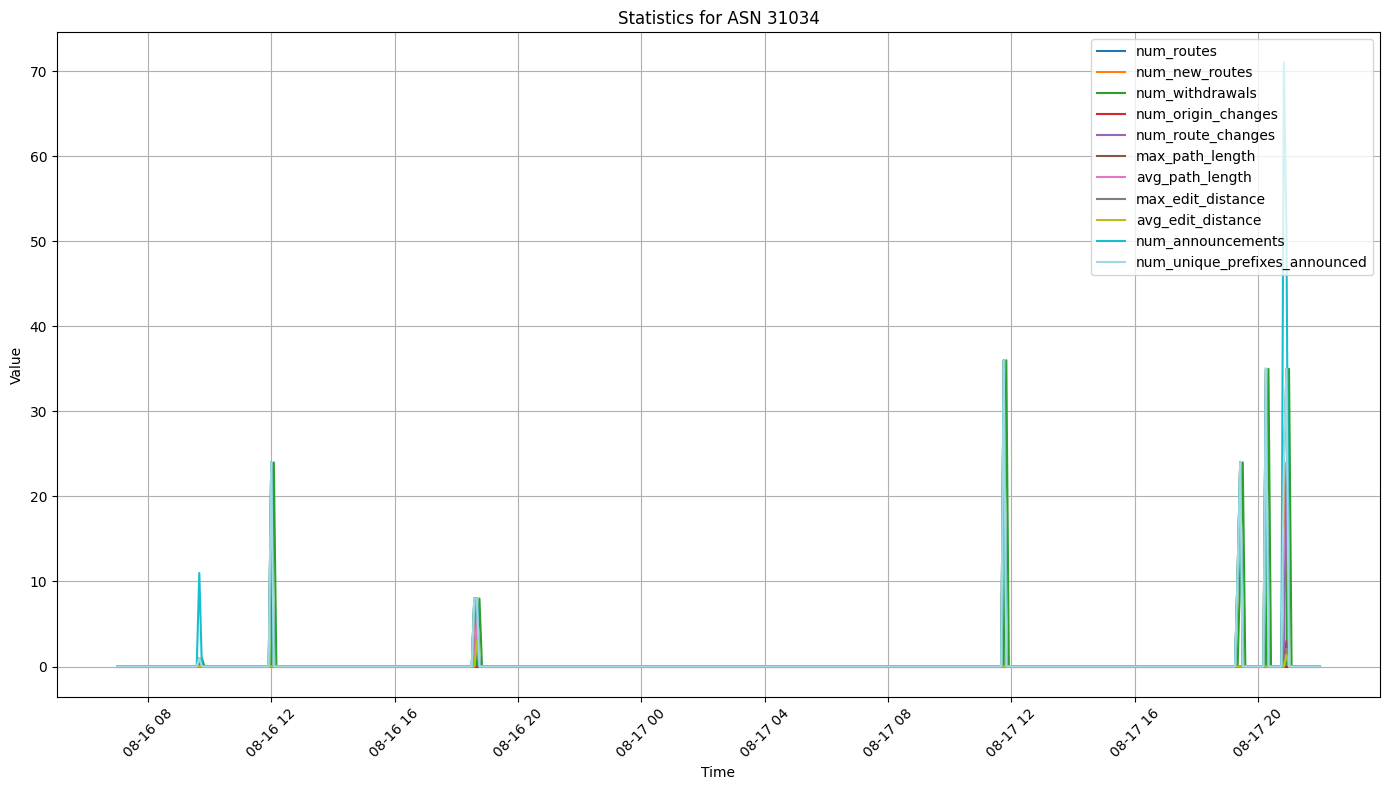

In [13]:
target_asn = "31034"
from_time = "2013-8-16 07:00:00"
until_time = "2013-8-17 22:00:00"
collectors = ["rrc00", "route-views2", "route-views3", "route-views4", "ris-ripe"]
output_file = f'bgp_features_asn_{target_asn}_ROS.csv'

df_features = extract_bgp_data(target_asn, from_time, until_time, collectors, output_file)
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns
plot_statistics(df_features, target_asn)

In [15]:
df_features = pd.read_csv("/home/hb/BGP_data_analysis/pybgpstream/bgp_features_asn_31034_ROS.csv")
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

df_features = detect_anomalies(df_features, numeric_cols, threshold_multiplier=2)
print(df_features[['timestamp', 'anomaly_status']])
df_features.to_csv(f'bgp_features_asn_31034_ROS_with_labels.csv', index=False)

              timestamp         anomaly_status
0   2013-08-16 07:00:00  no anomalies detected
1   2013-08-16 07:05:00  no anomalies detected
2   2013-08-16 07:10:00  no anomalies detected
3   2013-08-16 07:15:00  no anomalies detected
4   2013-08-16 07:20:00  no anomalies detected
..                  ...                    ...
464 2013-08-17 21:40:00  no anomalies detected
465 2013-08-17 21:45:00  no anomalies detected
466 2013-08-17 21:50:00  no anomalies detected
467 2013-08-17 21:55:00  no anomalies detected
468 2013-08-17 22:00:00  no anomalies detected

[469 rows x 2 columns]


# January 2017: Iranian pornography censorship
AS8529 - victim (receieved)
AS27589 - victim (hijacked)

Total records processed: 36275505
Total elements processed: 119080349
Data saved to bgp_features_asn_8529_iran.csv


/tmp/ipykernel_489684/1722542296.py:180: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', num_colors)


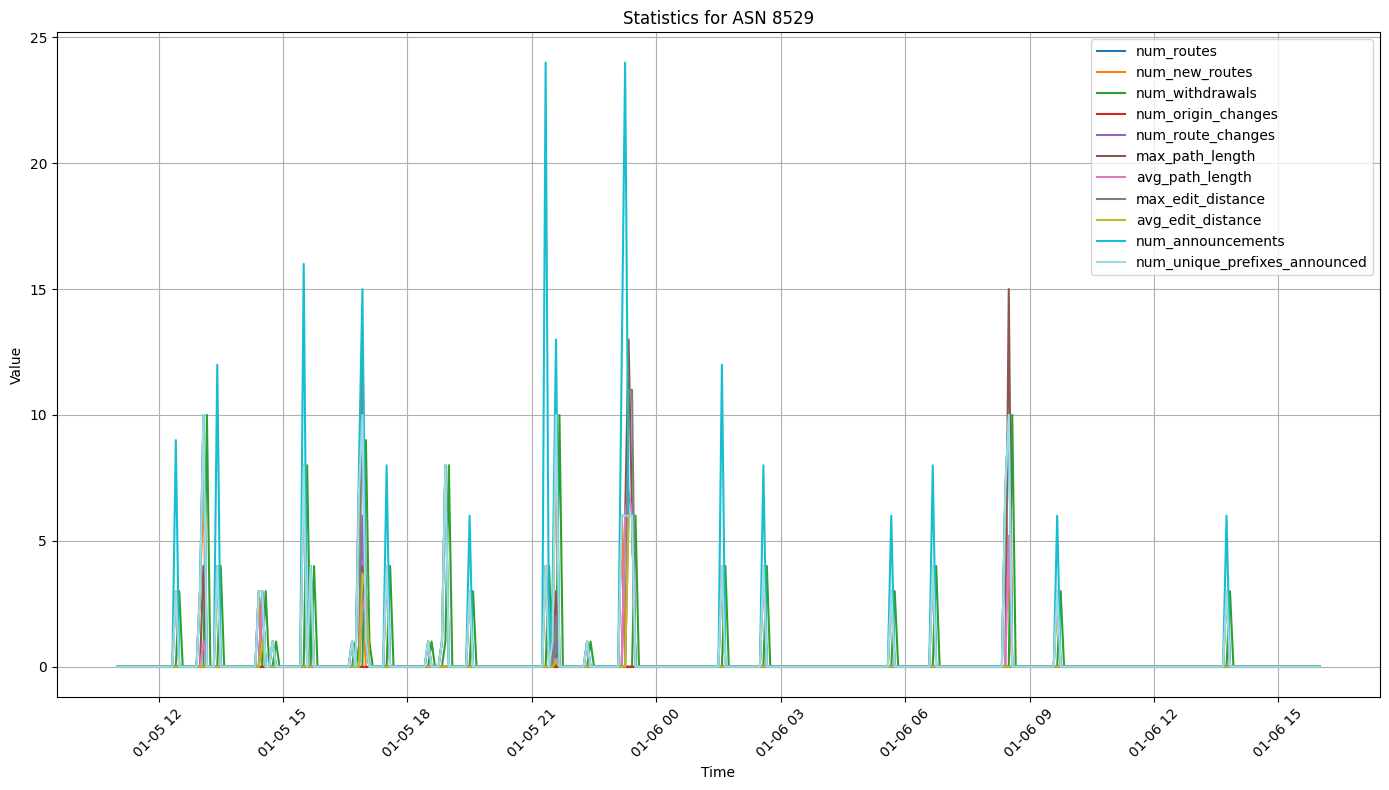

In [12]:
target_asn = "8529"
from_time = "2017-01-05 11:00:00"
until_time = "2017-01-06 16:00:00"
collectors = ["rrc00", "route-views2", "route-views3", "route-views4", "ris-ripe"]
output_file = f'bgp_features_asn_{target_asn}_iran.csv'

df_features = extract_bgp_data(target_asn, from_time, until_time, collectors, output_file)
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns
plot_statistics(df_features, target_asn)

In [16]:
df_features = pd.read_csv("/home/hb/BGP_data_analysis/pybgpstream/bgp_features_asn_8529_iran.csv")
df_features['timestamp'] = pd.to_datetime(df_features['timestamp'])
numeric_cols = df_features.select_dtypes(include=['number']).columns

df_features = detect_anomalies(df_features, numeric_cols, threshold_multiplier=2)
print(df_features[['timestamp', 'anomaly_status']])
df_features.to_csv(f'bgp_features_asn_8529_iran_with_labels.csv', index=False)

              timestamp         anomaly_status
0   2017-01-05 11:00:00  no anomalies detected
1   2017-01-05 11:05:00  no anomalies detected
2   2017-01-05 11:10:00  no anomalies detected
3   2017-01-05 11:15:00  no anomalies detected
4   2017-01-05 11:20:00  no anomalies detected
..                  ...                    ...
344 2017-01-06 15:40:00  no anomalies detected
345 2017-01-06 15:45:00  no anomalies detected
346 2017-01-06 15:50:00  no anomalies detected
347 2017-01-06 15:55:00  no anomalies detected
348 2017-01-06 16:00:00  no anomalies detected

[349 rows x 2 columns]
